In [1]:
import matplotlib.pyplot as plt
from protstruc import StructureBatch

In [2]:
struc = StructureBatch.from_pdb_id('5dk3')

In [3]:
xyz = struc.get_xyz()

In [4]:
xyz.shape

torch.Size([1, 1324, 15, 3])

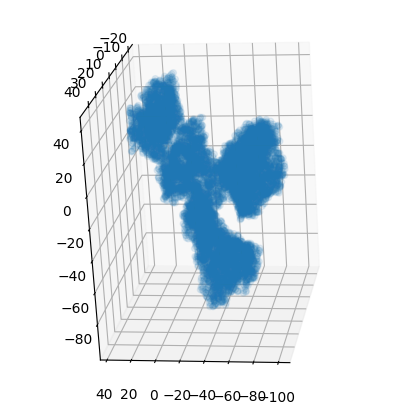

In [5]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xyz[0, :, :, 0], xyz[0, :, :, 1], xyz[0, :, :, 2],
    alpha=0.1, c='C0'
)
ax.view_init(-10, 20, 90)
plt.savefig('../../img/pembrolizumab.png', dpi=300, bbox_inches='tight')


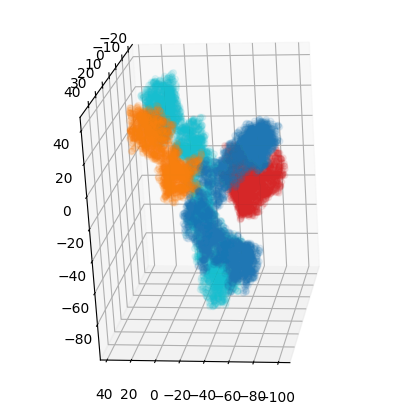

In [6]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

chain_idx = struc.get_chain_idx()[0]
chain_ids = struc.get_chain_ids()[0]

colors = ['C3', 'C0', 'C1', 'C9']
for idx, (chain_id, c) in enumerate(zip(chain_ids, colors)):
    mask = chain_idx == idx

    ax.scatter(
        xyz[0, mask, :, 0], xyz[0, mask, :, 1], xyz[0, mask, :, 2],
        alpha=0.1, c=c
    )
ax.view_init(-10, 20, 90)
plt.savefig('../../img/pembrolizumab_chain.png', dpi=300, bbox_inches='tight')


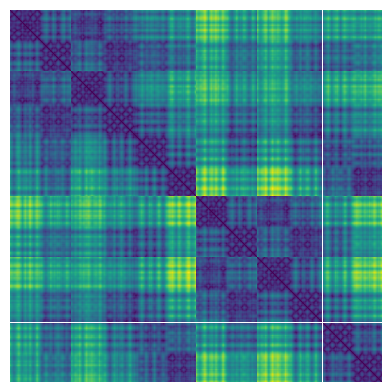

In [7]:
from protstruc.general import ATOM

struc = StructureBatch.from_pdb_id('5dk3')
distmat, distmat_mask = struc.pairwise_distance_matrix()
plt.matshow(distmat[0, :, :, ATOM.CA, ATOM.CA]);
plt.axis('off')

plt.savefig('../../img/pembrolizumab_distmat.png', dpi=300, bbox_inches='tight')

MovieWriter ffmpeg unavailable; using Pillow instead.


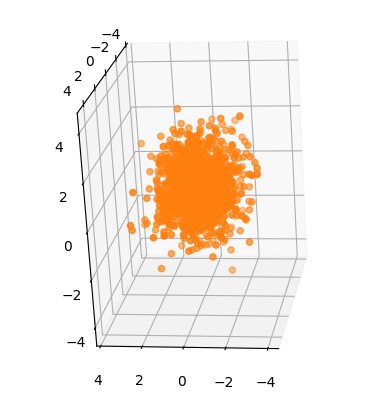

In [10]:
import torch
import math
import matplotlib.animation as animation

from protstruc.general import ATOM

def cosine_variance_schedule(T, s=8e-3, beta_max=0.999):
    # cosine variance schedule
    # T: total timesteps
    # s: small offset to prevent beta from being too small
    # beta_max: to prevent singularities at the end of the diffusion process
    t = torch.arange(T + 1)  # 0, 1, ..., T

    f_t = torch.cos((t / T + s) / (1 + s) * math.pi / 2.0).square()
    alpha_bar = f_t / f_t[0]
    beta = torch.cat(
        [
            torch.tensor([0.0]),
            torch.clip(1 - alpha_bar[1:] / alpha_bar[:-1], min=1e-5, max=beta_max),
        ]
    )
    alpha = 1 - beta

    sched = {
        "alpha": alpha,
        "alpha_bar": alpha_bar,
        "alpha_bar_sqrt": alpha_bar.sqrt(),
        "one_minus_alpha_bar_sqrt": (1 - alpha_bar).sqrt(),
        "beta": beta,
    }
    return sched

# Diffusion parameters
T = 300
sched = cosine_variance_schedule(T)
prt_idx, atom_idx = 0, ATOM.CA # only show Ca atoms for visual clarity

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

struc = StructureBatch.from_pdb_id('5dk3')
# Center atom coordinates at the origin and scale to unit variance
# NOTE: All atoms are considered here
struc.standardize()

ims = []
for t in range(T):
    xyz = struc.get_xyz()

    im1 = ax.scatter(
        xyz[prt_idx, :, atom_idx, 0],
        xyz[prt_idx, :, atom_idx, 1],
        xyz[prt_idx, :, atom_idx, 2],
        c='C1'
    )
    ax.view_init(-10, 20, 90)
    ims.append([im1])

    struc.diffuse_xyz(beta=torch.tensor([sched['beta'][t]]))

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
ani.save(f'animations/pembrolizumab_diffusion.gif')
